## Импорты

In [1]:
%matplotlib inline
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import gzip
import zipfile
import struct
import pickle
try:
    from PIL import Image
except ImportError:
    import Image
    
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf

2022-11-22 18:06:58.595769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 18:06:59.045268: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-22 18:06:59.131154: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alexstr/Dev/data_science_diplom/venv/lib/python3.8/site-packages/cv2/../../li

## Загрузка и обработка данных
В данном файле использую уже готовые датасеты.

In [2]:
# Загружаем данные изображений цифр
data_folder = os.path.join(os.getcwd(), '../data/mnist')
os.makedirs(data_folder, exist_ok=True)

In [3]:
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-images.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-labels.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 'test-images.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 'test-labels.gz'))

('/home/alexstr/Dev/data_science_diplom/notebooks/../data/mnist/test-labels.gz',
 <http.client.HTTPMessage at 0x7fa58746e3a0>)

In [3]:
# Загружаем данные киррилицы
comnist_data_folder = os.path.join(os.getcwd(), '../data/comnist')
os.makedirs(comnist_data_folder, exist_ok=True)

In [21]:
urllib.request.urlretrieve('https://github.com/GregVial/CoMNIST/raw/master/images/Cyrillic.zip',
                          filename=os.path.join(comnist_data_folder, 'cyrillic.zip'))

('/home/alexstr/Dev/data_science_diplom/notebooks/../data/comnist/cyrillic.zip',
 <http.client.HTTPMessage at 0x7f3e392d3ca0>)

In [10]:
# Разархивируем только буку "Н"
archive = zipfile.ZipFile('../data/comnist/cyrillic.zip')
n_path = '../data/comnist'
    
for file in archive.namelist():
    if file.startswith('Cyrillic/Н/'):
        archive.extract(file, n_path)

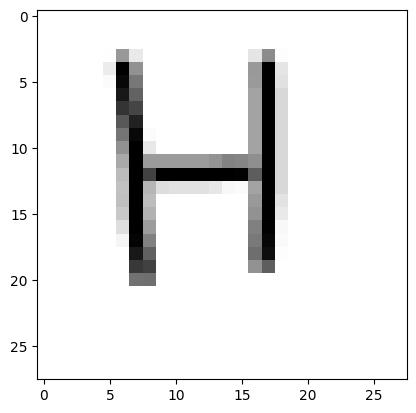

In [4]:
# Считываем пути ко всем буквам "н"
filelist = glob.glob('../data/comnist/Cyrillic/Н/*.png')

# Создаем массив с изображениями, удаляя лишнии каналы
n_letters = np.array([(np.array(Image.open(fname)))[:, :, 3] for fname in filelist])

# Преобразуем размер до 28*28 в одном измерении
n_letters = np.array([cv2.resize(letter, (28, 28), interpolation = cv2.INTER_AREA) for letter in n_letters])

plotting = plt.imshow(n_letters[0], cmap='gray_r')
plt.show()

# Конвертируем в формат, пригодный для обучения модели
n_letters = n_letters.reshape(508, 784,) / 255

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00392157
 0.40392157 0.08627451 0.         0.         0.         0.
 0.         0.         0.         0.         0.1

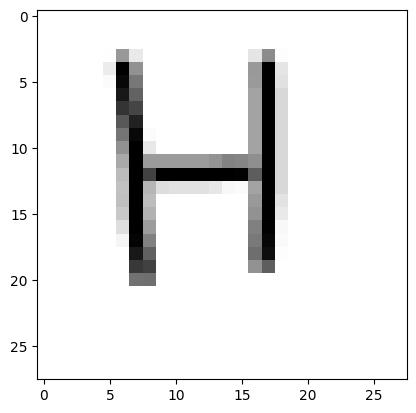

In [5]:
# Проверяем, что преобразования сделаны корректно
with np.printoptions(threshold=np.inf):
    print(n_letters[0])

letter = n_letters[0]
letter = letter.reshape(28,28)
plotting = plt.imshow(letter, cmap='gray_r')
plt.show()

In [12]:
# Делим на обучающую и тестовую выборку
x_n_letters_test = n_letters[430:]
x_n_letters_train = n_letters[:430]


In [13]:
y_n_letters_test = np.full(78, 6, dtype='float')
y_n_letters_train = np.full(430, 6, dtype='float')
y_n_letters_train.shape

(430,)

In [14]:
# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res

In [15]:
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(os.path.join(
    data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = load_data(os.path.join(
    data_folder, 'train-labels.gz'), True)
y_test = load_data(os.path.join(
    data_folder, 'test-labels.gz'), True)

In [16]:
y_train = y_train.reshape(60000,)

y_test = y_test.reshape(10000,)

In [17]:
train_filter = np.where((y_train < 6))
test_filter = np.where((y_test < 6))

In [18]:
# Убираем лишние цифры
X_train, y_train = X_train[train_filter], y_train[train_filter]
X_test, y_test = X_test[test_filter], y_test[test_filter]

In [19]:
# Объединяем все массивы
X_train = np.concatenate((X_train, x_n_letters_train))
X_test = np.concatenate((X_test, x_n_letters_test))

y_train = np.concatenate((y_train, y_n_letters_train))
y_test = np.concatenate((y_test, y_n_letters_test))

## Разработка модели

In [14]:
k_neibors = KNeighborsClassifier()
param_grid_neibors = {'n_neighbors': [5, 10, 15, 30]}
best_k_neibors = GridSearchCV(k_neibors, param_grid_neibors)

best_k_neibors.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 10, 15, 30]})

In [17]:
best_k_neibors_pred = best_k_neibors.predict(X_test)
print(f"The model is {accuracy_score(best_k_neibors_pred, y_test)*100}% accurate")

The model is 98.52676379112785% accurate


In [16]:
model_folder = os.path.join(os.getcwd(), '../models')
os.makedirs(model_folder, exist_ok=True)

filename = '../models/k_neibors_model.sav'
pickle.dump(best_k_neibors, open(filename, 'wb'))

In [18]:
forest = RandomForestClassifier()
param_grid_forest = {
    'n_estimators': [10, 20, 50],
    'random_state': [0, 5, 20, 40]
}
best_forest = GridSearchCV(forest, param_grid_forest)
best_forest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [10, 20, 50],
                         'random_state': [0, 5, 20, 40]})

In [20]:
best_forest_pred = best_forest.predict(X_test)
print(f"The model is {accuracy_score(best_forest_pred, y_test)*100}% accurate")

The model is 98.39580946145033% accurate


In [19]:
model_folder = os.path.join(os.getcwd(), '../models')
os.makedirs(model_folder, exist_ok=True)

filename = '../models/forest_model.sav'
pickle.dump(best_forest, open(filename, 'wb'))

In [1]:
# Мой компьбтер не в состоянии это выдержать ;(
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc_with_grid_search = svm.SVC(probability=True)
svc_with_grid_search = GridSearchCV(svc,param_grid)
best_svc.fit(X_train, y_train)

NameError: name 'svm' is not defined

In [ ]:
svc_poly = svm.SVC(kernel='poly', degree=8)

svc_poly.fit(X_train, y_train)
svc_poly_predicted = svc_poly.predict(X_test)

In [ ]:
print(f"The model is {accuracy_score(svc_poly_predicted, y_test)*100}% accurate")

In [ ]:
model_folder = os.path.join(os.getcwd(), '../models')
os.makedirs(model_folder, exist_ok=True)

filename = '../models/svc_poly.sav'
pickle.dump(svc_poly, open(filename, 'wb'))

Предобработка данных для обучения нейронки

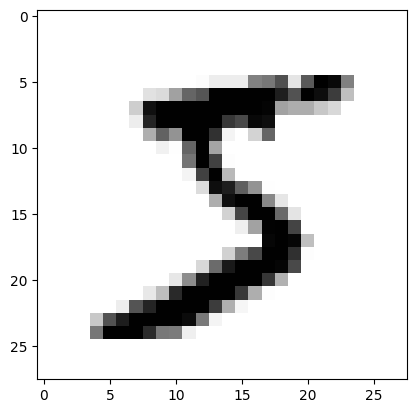

In [15]:
X_nn_train = X_train.reshape(36447, 28, 28)
X_nn_test = X_test.reshape(6109, 28, 28)
plotting = plt.imshow(X_nn_train[0], cmap='gray_r')
plt.show()


In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

2022-11-19 16:16:42.223866: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alexstr/Dev/data_science_diplom/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-19 16:16:42.223916: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-19 16:16:42.223930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-PELI220): /proc/driver/nvidia/version does not exist
2022-11-19 16:16:42.224124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations

In [17]:
model.fit(X_nn_train, y_train, epochs=30, validation_split=0.3)

test_loss, test_acc = model.evaluate(X_nn_test,  y_test, verbose=0)

print('Точность на тестовом множестве:', test_acc)

Epoch 1/30
798/798 [==============================] - 3s 3ms/step - loss: 0.1672 - accuracy: 0.9504 - val_loss: 0.3624 - val_accuracy: 0.9363
Epoch 2/30
798/798 [==============================] - 2s 2ms/step - loss: 0.0590 - accuracy: 0.9811 - val_loss: 0.4295 - val_accuracy: 0.9418
Epoch 3/30
798/798 [==============================] - 2s 2ms/step - loss: 0.0359 - accuracy: 0.9884 - val_loss: 0.4410 - val_accuracy: 0.9446
Epoch 4/30
798/798 [==============================] - 2s 2ms/step - loss: 0.0245 - accuracy: 0.9918 - val_loss: 0.5233 - val_accuracy: 0.9428
Epoch 5/30
798/798 [==============================] - 2s 2ms/step - loss: 0.0198 - accuracy: 0.9937 - val_loss: 0.5269 - val_accuracy: 0.9447
Epoch 6/30
798/798 [==============================] - 2s 3ms/step - loss: 0.0136 - accuracy: 0.9952 - val_loss: 0.6080 - val_accuracy: 0.9447
Epoch 7/30
798/798 [==============================] - 2s 2ms/step - loss: 0.0115 - accuracy: 0.9964 - val_loss: 0.6969 - val_accuracy: 0.9412
Epoch 

In [21]:
model.save('../models/nn_model.h5', save_format="h5")

In [20]:
y_test[0]

2.0